## Machine learning modeling - Iteration #1

1. [Preliminary Feature Purging](#preliminary_feature_purging)
1. [Target Feature Preparation](#feature_preparation)
1. [Examine Feature Importances](#feature_importances)
1. [Random Forrest Classifier](#random_forrest_classifier)
1. [Support Vector Classifier](#support_vector_classifier)
1. [KNN Classifier](#knn)
1. [Gradient Boost Classifier](#gradient_boost_classifier)


In [75]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.options.display.max_rows = 999

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample

In [2]:
# read in 990 data that has been
# subsetted and cleaned in 990_cont_comp_EDA notebook
df = pd.read_csv('data/990_model_data.csv')

In [3]:
df.shape

(26881, 105)

In [4]:
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,phone,website,address,city,state,zip,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP
0,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,046190425,True,False,False,False,1940.0,ME,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.081081,0.061503
1,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,04104,True,False,False,False,1931.0,ME,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.033708,0.137033
2,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive,Augusta,ME,04330,True,False,False,False,1859.0,ME,False,False,5_,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,835457

<a id="preliminary_feature_purging"></a>
### Preliminary Feature Purging: remove features I have deemed to not contribute significant information to the models

In [5]:
# drop columns at beginning of dataset
# contact information for the org
# that I have determined aren't significant
df.drop(df.loc[:,'ein': 'zip'].columns, axis=1, inplace=True)

# drop columns at end of dataset
# that contain unique identifiers for tax return purposes
df.drop(df.loc[:,'record_id': 'random_string'].columns, axis=1, inplace=True)

In [6]:
# drop specific contractor info
# these will have a lot of nans for contractors 2, 3, 4, 5
# also the categories of services provided by 
# various vendors are very messy

df.drop(df.loc[:,'name_contractor_1': 'amt_paid_contractor_5'].columns, axis=1, inplace=True)

<a id="feature_preparation"></a>
## Create Target Features

#### 1. df['CON_CT_DIV_EMP_VOL_CT_flag']
Identify orgs with a high number of contractors and a low number of employees and volunteers

In [8]:
# find the 75th percentile
np.percentile(df['CON_CT_DIV_EMP_VOL_CT'], [75])

array([0.05627706])

In [9]:
# what percent of the total does the 75th quartile make up?
df[df['CON_CT_DIV_EMP_VOL_CT'] > np.percentile(df['CON_CT_DIV_EMP_VOL_CT'], [75])[0]].shape[0] / df.shape[0]

0.24999069975075333

In [10]:
# create flag column for orgs with 
# ratio above threshold
df['CON_CT_DIV_EMP_VOL_CT_flag'] = np.where(df['CON_CT_DIV_EMP_VOL_CT'] >= np.percentile(df['CON_CT_DIV_EMP_VOL_CT'],
                                                                               [75])[0], True, False)

In [11]:
# how many fall into each category?
df['CON_CT_DIV_EMP_VOL_CT_flag'].value_counts()

False    20160
True      6721
Name: CON_CT_DIV_EMP_VOL_CT_flag, dtype: int64

#### 2. df['CON_EXP_DIV_TOT_EXP_flag']
Identify orgs with contractor payments making up a high percentage of total expenses

In [12]:
# find the 75th percentile
np.percentile(df['CON_EXP_DIV_TOT_EXP'], [75])

array([0.2972561])

In [13]:
# what percent of the total does the 75th quartile make up?
df[df['CON_EXP_DIV_TOT_EXP'] > np.percentile(df['CON_EXP_DIV_TOT_EXP'], [75])[0]].shape[0] / df.shape[0]

0.24999069975075333

In [14]:
# create flag column for orgs with
# ratio above threshold
df['CON_EXP_DIV_TOT_EXP_flag'] = np.where(df['CON_EXP_DIV_TOT_EXP'] >= np.percentile(df['CON_EXP_DIV_TOT_EXP'],
                                                                               [75])[0], True, False)

In [15]:
# how many fall into each category?
df['CON_EXP_DIV_TOT_EXP_flag'].value_counts()

False    20160
True      6721
Name: CON_EXP_DIV_TOT_EXP_flag, dtype: int64

#### Flag Combinations, the intersection of 1 and 2 above will become the target feature I am trying to classify.

In [16]:
# how many orgs are flagged by both flags
df[(df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)].shape

(2909, 52)

In [17]:
# what percent is that of the total?
df[(df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)].shape[0] / \
df.shape[0]

0.10821770023436628

About 10%

In [18]:
df['TARGET_FEATURE'] = (df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)

In [19]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE
0,True,False,False,False,1940.0,ME,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False
1,True,False,False,False,1931.0,ME,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,3,0.033708,0.137033,False,False,False
2,True,False,False,False,1859.0,ME,False,False,5_,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0.0,6033969.0,0.0,0,2223320.0,8410104.0,-55531.0,3510564.0,820701.0,2689863.0,778662,7607073,45921,0,8431656,224247,0,6018982,0,2118455,8361684,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False
3,True,False,False,False,1917.0,ME,False,True,3_,57422298,8,7,442,15.0,0,0.0,450238.0,51510597.0,183397.0,8387.0,52152619.0,1000.0,0.0,22671669.0,0.0,0,26926818.0,49599487.0,2553132.0,57577945.0,13230564.0,44347381.0,327318,53676954,124583,19669,54148524,0,0,24500108,0,29557786,54057894,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False
4,True,False,False,False,1895.0,ME,False,False,7_,5974176,12,12,139,50.0,2437,1437.0,0.0,3188739.0,608.0,263734.0,3453081.0,0.0,0.0,1381856.0,0.0,0,1726973.0,3108829.0,344252.0,9803605.0,3104088.0,6699517.0,0,3507190,1347,492375,4000912,0,0,1463461,0,1791727,3255188,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False


#### Visualize Target Feature Intersection

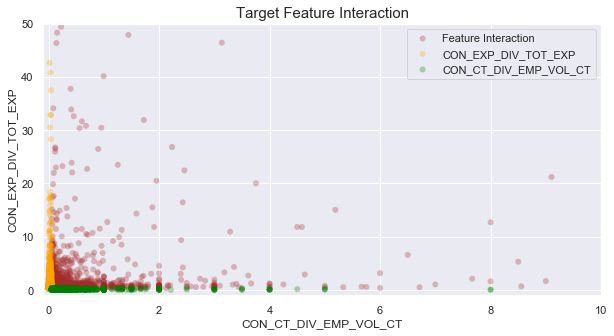

In [101]:
fig = plt.figure(figsize=(10, 5))

# intersection area
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='brown',
           alpha=.3,
           edgecolor="none",
               label='Feature Interaction')

# cont exp div by tot exp
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == False, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='orange',
           alpha=.3,
           edgecolor="none",
               label='CON_EXP_DIV_TOT_EXP')

# cont ct div emp ct
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == False, 'CON_EXP_DIV_TOT_EXP'],
           color='green',
           alpha=.3,
           edgecolor="none",
               label='CON_CT_DIV_EMP_VOL_CT')

plt.xlim(-.1, 10)
plt.ylim(-1, 50)

plt.title('Target Feature Interaction', fontsize=15)
plt.savefig('visualizations/feature_interaction_three_1.png');

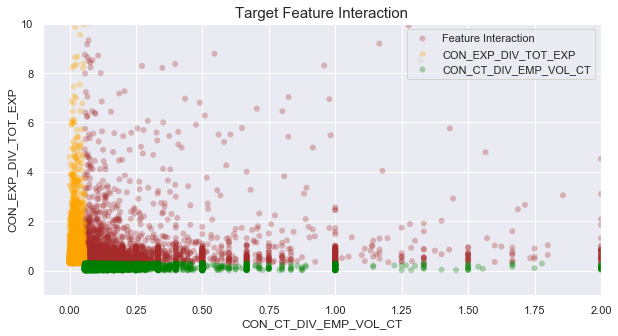

In [102]:
fig = plt.figure(figsize=(10, 5))

# intersection area
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='brown',
           alpha=.3,
           edgecolor="none",
               label='Feature Interaction')

# cont exp div by tot exp
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == False, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='orange',
           alpha=.3,
           edgecolor="none",
               label='CON_EXP_DIV_TOT_EXP')

# cont ct div emp ct
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == False, 'CON_EXP_DIV_TOT_EXP'],
           color='green',
           alpha=.3,
           edgecolor="none",
               label='CON_CT_DIV_EMP_VOL_CT')

plt.xlim(-.1, 2)
plt.ylim(-1, 10)

plt.title('Target Feature Interaction', fontsize=15)
plt.savefig('visualizations/feature_interaction_three_2.png');

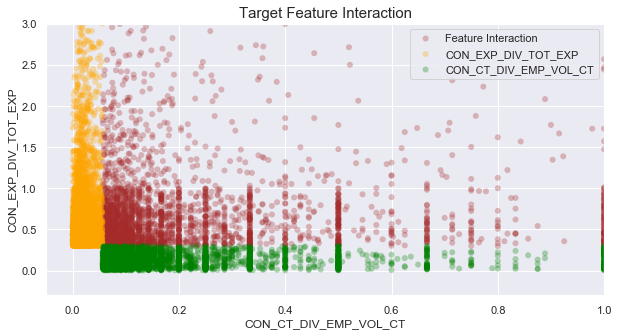

In [103]:
fig = plt.figure(figsize=(10, 5))

# intersection area
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='brown',
           alpha=.3,
           edgecolor="none",
               label='Feature Interaction')

# cont exp div by tot exp
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == False, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'CON_EXP_DIV_TOT_EXP'],
           color='orange',
           alpha=.3,
           edgecolor="none",
               label='CON_EXP_DIV_TOT_EXP')

# cont ct div emp ct
sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'CON_CT_DIV_EMP_VOL_CT'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == False, 'CON_EXP_DIV_TOT_EXP'],
           color='green',
           alpha=.3,
           edgecolor="none",
               label='CON_CT_DIV_EMP_VOL_CT')

plt.xlim(-.05, 1)
plt.ylim(-.3, 3)

plt.title('Target Feature Interaction', fontsize=15)
plt.savefig('visualizations/feature_interaction_three_3.png');

### Feature interaction between dataset features

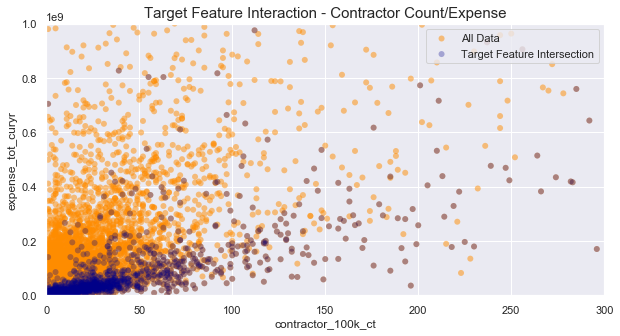

In [91]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df.contractor_100k_ct, df.expense_tot_curyr, color='darkorange', alpha=.5, edgecolor="none",
               label='All Data');

sns.scatterplot(df.loc[df.CON_CT_DIV_EMP_VOL_CT_flag == True, 'contractor_100k_ct'],
           df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'expense_tot_curyr'],
           color='darkblue',
           alpha=.3,
           edgecolor="none",
           label='Target Feature Intersection')

plt.legend(loc='upper right')
plt.xlim(0, 300)
plt.ylim(0, 1000000000)
plt.title('Target Feature Interaction - Contractor Count/Expense', fontsize=15)
plt.savefig('visualizations/feature_interaction_exp.png');

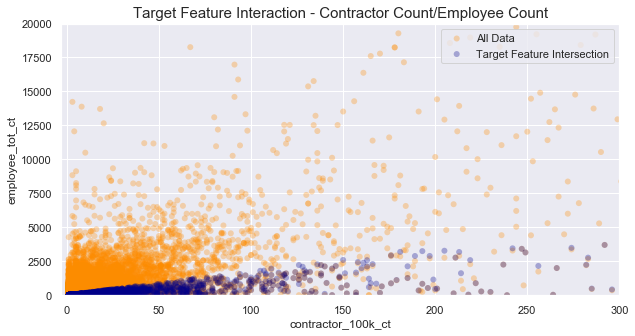

In [117]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df.contractor_100k_ct, df.employee_tot_ct, color='darkorange', alpha=.3, edgecolor="none",
                label='All Data')

sns.scatterplot(df.loc[df.TARGET_FEATURE == True, 'contractor_100k_ct'],
           df.loc[df.TARGET_FEATURE == True, 'employee_tot_ct'] + df.loc[df.CON_EXP_DIV_TOT_EXP_flag == True, 'volunteer_tot_ct'],
           color='darkblue',
           alpha=.3,
           edgecolor="none",
            label='Target Feature Intersection')

plt.legend(loc='upper right')
plt.xlim(-3, 300)
plt.ylim(-10, 20000)
plt.title('Target Feature Interaction - Contractor Count/Employee Count', fontsize=15)
# plt.savefig('visualizations/feature_interaction_employee.png');

<a id="feature_importances"></a>
## Examine Feature Importances


### Correlation matrix to examine relationships between features and target variable

In [184]:
# how large is my dataset when I get dummies?
pd.get_dummies(df).shape

(26881, 376)

In [185]:
# identify features correlated with my target variable
pd.get_dummies(df).corr().loc[:,'TARGET_FEATURE'].sort_values(ascending=False).head(20)

TARGET_FEATURE                1.000000
CON_CT_DIV_EMP_VOL_CT_flag    0.603320
CON_EXP_DIV_TOT_EXP_flag      0.603320
exempt_status_501c_txt_4_     0.121435
exempt_status_501c_txt_6_     0.114429
formation_yr_2015.0           0.069566
formation_yr_2013.0           0.061226
exempt_status_501c_txt_14_    0.057464
formation_yr_2016.0           0.051619
state_legaldomicile_DE        0.051600
formation_yr_2014.0           0.048039
state_legaldomicile_DC        0.046693
exempt_status_501c_txt_25_    0.042477
formation_yr_2012.0           0.041632
formation_yr_2011.0           0.038424
exempt_status_501c_txt_2_     0.033299
exempt_status_501c_txt_27_    0.030328
formation_yr_2005.0           0.030164
formation_yr_2004.0           0.029553
formation_yr_2010.0           0.029061
Name: TARGET_FEATURE, dtype: float64

In [186]:
# identify the top 30 features most correlated with target feature
top_corr = list(pd.get_dummies(df).corr().loc[:,'TARGET_FEATURE'].sort_values(ascending=False).head(30).index)

In [187]:
pd.get_dummies(df)[top_corr]

,TARGET_FEATURE,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,exempt_status_501c_txt_4_,exempt_status_501c_txt_6_,formation_yr_2015.0,formation_yr_2013.0,exempt_status_501c_txt_14_,formation_yr_2016.0,state_legaldomicile_DE,formation_yr_2014.0,state_legaldomicile_DC,exempt_status_501c_txt_25_,formation_yr_2012.0,formation_yr_2011.0,exempt_status_501c_txt_2_,exempt_status_501c_txt_27_,formation_yr_2005.0,formation_yr_2004.0,formation_yr_2010.0,formation_yr_2008.0,exempt_status_501c_txt_13_,CON_CT_DIV_EMP_VOL_CT,formation_yr_2009.0,formation_yr_2006.0,CON_EXP_DIV_TOT_EXP,formation_yr_1996.0,state_legaldomicile_MI,other_expense_tot_curyr,other_expense_tot_prioryr
0,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.081081,0,0,0.061503,0,0,14038980,13694568.0
1,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.033708,0,0,0.137033,0,0,4052976,3456770.0
2,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011858,0,0,0.053652,0,0,2118455,2223320.0
3,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.017505,0,0,0.039592,0,0,29557786,26926818.0
4,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005291,0,0,0.039945,0,0,1791727,1726973.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26876,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005229,0,0,0.071791,0,0,4069937,4052793.0
26877,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.000000,0,0,0.048544,0,0,2868165,2824638.0
26878,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005780,0,0,0.290554,0,0,3423848,0.0
26879,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0.087807,0,0,629713,658739.0


(30.0, 0.0)

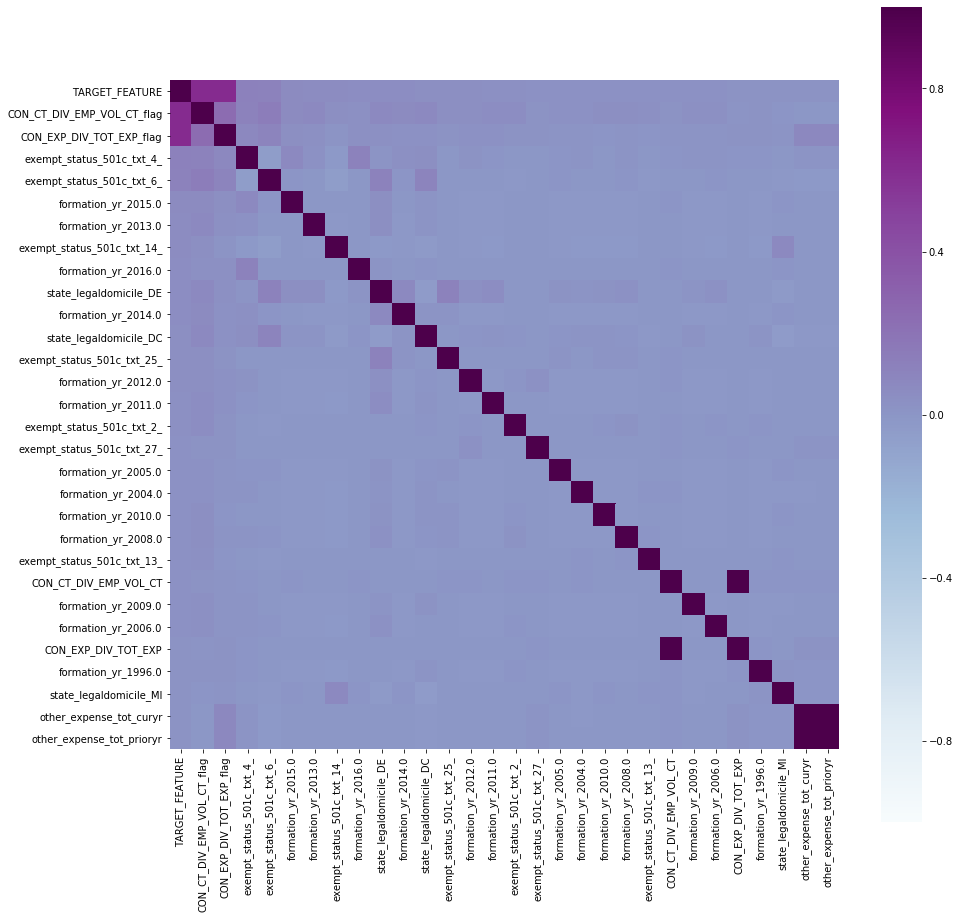

In [188]:
# compare features using a heatmap
# focusing only on features most correlated with 
# target variable
plt.figure(figsize=(15, 15))

ax = sns.heatmap(pd.get_dummies(df)[top_corr].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap='BuPu')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Random forest to examine relationships between features and target variable

In [189]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            ], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [190]:
X.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,grp_return,exempt_status_501c3,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,TARGET_FEATURE,formation_yr_1096.0,formation_yr_1645.0,formation_yr_1650.0,formation_yr_1660.0,formation_yr_1689.0,formation_yr_1701.0,formation_yr_1709.0,formation_yr_1731.0,formation_yr_1740.0,formation_yr_1746.0,formation_yr_1749.0,formation_yr_1751.0,formation_yr_1754.0,formation_yr_1759.0,formation_yr_1763.0,formation_yr_1764.0,formation_yr_1765.0,formation_yr_1766.0,formation_yr_1769.0,formation_yr_1772.0,formation_yr_1774.0,formation_yr_1778.0,formation_yr_1780.0,formation_yr_1781.0,formation_yr_1782.0,formation_yr_1783.0,formation_yr_1784.0,formation_yr_1785.0,formation_yr_1787.0,formation_yr_1789.0,formation_yr_1791.0,formation_yr_1792.0,formation_yr_1793.0,formation_yr_1794.0,formation_yr_1795.0,formation_yr_1797.0,formation_yr_1798.0,formation_yr_1799.0,formation_yr_1800.0,formation_yr_1801.0,formation_yr_1802.0,formation_yr_1805.0,formation_yr_1806.0,formation_yr_1807.0,formation_yr_1808.0,formation_yr_1809.0,formation_yr_1810.0,formation_yr_1811.0,formation_yr_1812.0,formation_yr_1813.0,formation_yr_1814.0,formation_yr_1815.0,formation_yr_1816.0,formation_yr_1817.0,formation_yr_1818.0,formation_yr_1819.0,formation_yr_1820.0,formation_yr_1821.0,formation_yr_1823.0,formation_yr_1824.0,formation_yr_1825.0,formation_yr_1826.0,formation_yr_1827.0,formation_yr_1828.0,formation_yr_1829.0,formation_yr_1830.0,formation_yr_1831.0,formation_yr_1832.0,formation_yr_1833.0,formation_yr_1834.0,formation_yr_1835.0,formation_yr_1836.0,formation_yr_1837.0,formation_yr_1838.0,formation_yr_1839.0,formation_yr_1840.0,formation_yr_1841.0,formation_yr_1842.0,formation_yr_1843.0,formation_yr_1844.0,formation_yr_1845.0,formation_yr_1846.0,formation_yr_1847.0,formation_yr_1848.0,formation_yr_1849.0,formation_yr_1850.0,formation_yr_1851.0,formation_yr_1852.0,formation_yr_1853.0,formation_yr_1854.0,formation_yr_1855.0,formation_yr_1856.0,formation_yr_1857.0,formation_yr_1858.0,formation_yr_1859.0,formation_yr_1860.0,formation_yr_1861.0,formation_yr_1862.0,formation_yr_1863.0,formation_yr_1864.0,formation_yr_1865.0,formation_yr_1866.0,formation_yr_1867.0,formation_yr_1868.0,formation_yr_1869.0,formation_yr_1870.0,formation_yr_1871.0,formation_yr_1872.0,formation_yr_1873.0,formation_yr_1874.0,formation_yr_1875.0,formation_yr_1876.0,formation_yr_1877.0,formation_yr_1878.0,formation_yr_1879.0,formation_yr_1880.0,formation_yr_1881.0,formation_yr_1882.0,formation_yr_1883.0,formation_yr_1884.0,formation_yr_1885.0,formation_yr_1886.0,formation_yr_1887.0,formation_yr_1888.0,formation_yr_1889.0,formation_yr_1890.0,formation_yr_1891.0,formation_yr_1892.0,formation_yr_1893.0,formation_yr_1894.0,formation_yr_1895.0,formation_yr_1896.0,formation_yr_1897.0,formation_yr_1898.0,formation_yr_1899.0,formation_yr_1900.0,formation_yr_1901.0,formation_yr_1902.0,formation_yr_1903.0,formation_yr_1904.0,formation_yr_1905.0,formation_yr_1906.0,formation_yr_1907.0,formation_yr_1908.0,formation_yr_1909.0,formation_yr_1910.0,formation_yr_1911.0,formation_yr_1912.0,formation_yr_1913.0,formation_yr_1914.0,formation_yr_1915.0,forma

### Random Forrest Classifier 


In [193]:
rfc = ensemble.RandomForestClassifier(n_estimators=500, max_depth=4)

rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

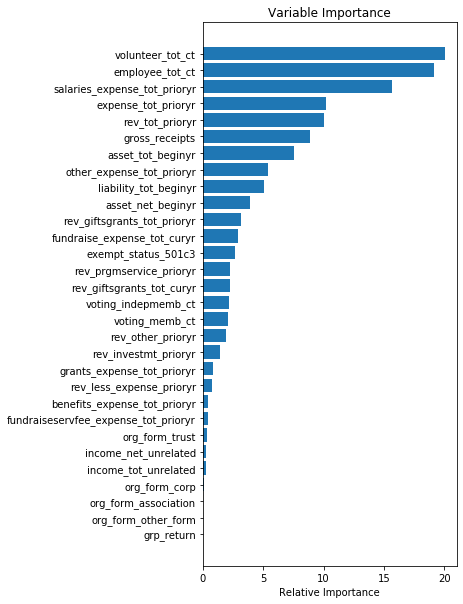

In [194]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())[0:30]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

It makes sense that employee total count and volunteer total count are at the top since I used them to compute my target feature.

### Secondary Feature Purging: after deeper feature investigation, remove features I have deemed to not contribute significant information to the models

In [195]:
# remove year since it didn't seem to add any additional information
df.drop('formation_yr', axis=1, inplace=True)

In [196]:
# drop state_legaldomicile
df.drop('state_legaldomicile', axis=1, inplace=True)

In [199]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE
0,True,False,False,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False
1,True,False,False,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,3,0.033708,0.137033,False,False,False
2,True,False,False,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0.0,6033969.0,0.0,0,2223320.0,8410104.0,-55531.0,3510564.0,820701.0,2689863.0,778662,7607073,45921,0,8431656,224247,0,6018982,0,2118455,8361684,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False
3,True,False,False,False,False,True,3_,57422298,8,7,442,15.0,0,0.0,450238.0,51510597.0,183397.0,8387.0,52152619.0,1000.0,0.0,22671669.0,0.0,0,26926818.0,49599487.0,2553132.0,57577945.0,13230564.0,44347381.0,327318,53676954,124583,19669,54148524,0,0,24500108,0,29557786,54057894,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False
4,True,False,False,False,False,False,7_,5974176,12,12,139,50.0,2437,1437.0,0.0,3188739.0,608.0,263734.0,3453081.0,0.0,0.0,1381856.0,0.0,0,1726973.0,3108829.0,344252.0,9803605.0,3104088.0,6699517.0,0,3507190,1347,492375,4000912,0,0,1463461,0,1791727,3255188,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False


In [200]:
# drop other misc columns
df.drop(['grp_return'], axis=1, inplace=True)

In [201]:
# remove 'exempt_status.501c3' & 'exempt_status.501c_any' 
# since this information is being captured in exempt_status.501c_txt
df.drop(['exempt_status_501c3'], axis=1, inplace=True)

#### Consolidate Features
Examining the correlation heatmap, many of the financial amounts seem to be correlated with each other.  Using PCA, I will consolidate all the revenue features, as well as all of the expense features.

(13.0, 0.0)

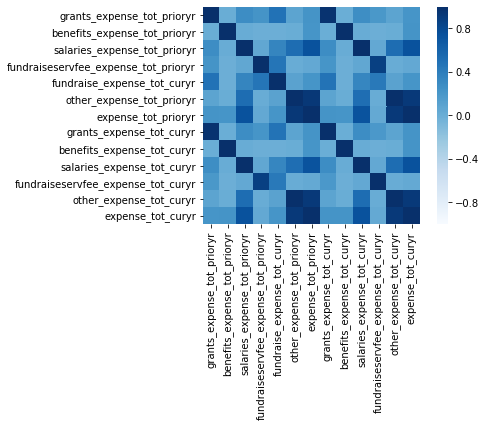

In [202]:
# plt.figure(figsize=(15, 15))

ax = sns.heatmap(df[['grants_expense_tot_prioryr',
 'benefits_expense_tot_prioryr',
 'salaries_expense_tot_prioryr',
 'fundraiseservfee_expense_tot_prioryr',
 'fundraise_expense_tot_curyr',
 'other_expense_tot_prioryr',
 'expense_tot_prioryr',
 'grants_expense_tot_curyr',
 'benefits_expense_tot_curyr',
 'salaries_expense_tot_curyr',
 'fundraiseservfee_expense_tot_curyr',
 'other_expense_tot_curyr',
 'expense_tot_curyr']].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(11.0, 0.0)

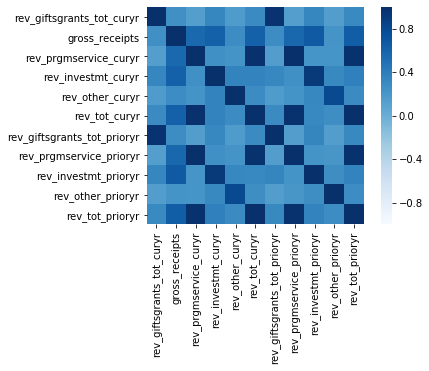

In [203]:
# plt.figure(figsize=(15, 15))

ax = sns.heatmap(df[['rev_giftsgrants_tot_curyr',
    'gross_receipts',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [204]:
# consolidate rev features
pca = PCA(n_components=1)
df['rev_PCA'] = pca.fit_transform(df[['rev_giftsgrants_tot_curyr',
#     'gross_receipts',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']])                                
                                     

print(pca.explained_variance_ratio_)

[0.97690954]


In [205]:
# remove rev features that have been consolidated
df.drop(df[['rev_giftsgrants_tot_curyr',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']], axis=1, inplace=True)

In [206]:
# consolidate exp features
pca = PCA(n_components=1)
df['exp_PCA'] = pca.fit_transform(
         df[['grants_expense_tot_prioryr',
         'benefits_expense_tot_prioryr',
         'salaries_expense_tot_prioryr',
         'fundraiseservfee_expense_tot_prioryr',
         'fundraise_expense_tot_curyr',
         'other_expense_tot_prioryr',
         'expense_tot_prioryr',
         'grants_expense_tot_curyr',
         'benefits_expense_tot_curyr',
         'salaries_expense_tot_curyr',
         'fundraiseservfee_expense_tot_curyr',
         'other_expense_tot_curyr',
         'expense_tot_curyr']])                                
                                     

print(pca.explained_variance_ratio_)

[0.90936043]


In [207]:
# remove exp features that have been consolidated
df.drop(df[['grants_expense_tot_prioryr',
         'benefits_expense_tot_prioryr',
         'salaries_expense_tot_prioryr',
         'fundraiseservfee_expense_tot_prioryr',
         'fundraise_expense_tot_curyr',
         'other_expense_tot_prioryr',
         'expense_tot_prioryr',
         'grants_expense_tot_curyr',
         'benefits_expense_tot_curyr',
         'salaries_expense_tot_curyr',
         'fundraiseservfee_expense_tot_curyr',
         'other_expense_tot_curyr',
         'expense_tot_curyr']], axis=1, inplace=True)

In [433]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [483]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [486]:
X.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,rev_PCA,exp_PCA,exempt_status_501c_txt_10_,exempt_status_501c_txt_12_,exempt_status_501c_txt_13_,exempt_status_501c_txt_14_,exempt_status_501c_txt_18_,exempt_status_501c_txt_19_,exempt_status_501c_txt_23_,exempt_status_501c_txt_25_,exempt_status_501c_txt_26_,exempt_status_501c_txt_27_,exempt_status_501c_txt_29_,exempt_status_501c_txt_2_,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_5_,exempt_status_501c_txt_6_,exempt_status_501c_txt_7_,exempt_status_501c_txt_8_,exempt_status_501c_txt_9_
0,True,False,False,False,15549792,11,11,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,-9.230988e+07,-7.560677e+07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,False,False,False,9472036,9,8,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,-1.057983e+08,-9.231641e+07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,8503978,21,19,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,-1.072903e+08,-9.229491e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,True,False,False,False,57422298,8,7,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,-1.765087e+07,-1.757254e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,True,False,False,False,5974176,12,12,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,-1.162458e+08,-9.964548e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [487]:
X.shape

(26881, 38)

In [446]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [447]:
X.shape

(26881, 38)

<a id="random_forrest_classifier"></a>

## Random Forest Classifier 

In [437]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.89585271, 0.89306305, 0.89508929, 0.89583333, 0.89730233])

In [439]:
rfc.fit(X_train, y_train)

# test model on unseen data
predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0016741071428571428
Percent Type II errors: 0.09398251488095238

Test set accuracy:
Percent Type I errors: 0.005207364701506416
Percent Type II errors: 0.09298865538404315


In [440]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19108,36
Actual: Yes,2021,339


In [441]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4800,28
Actual: Yes,500,49


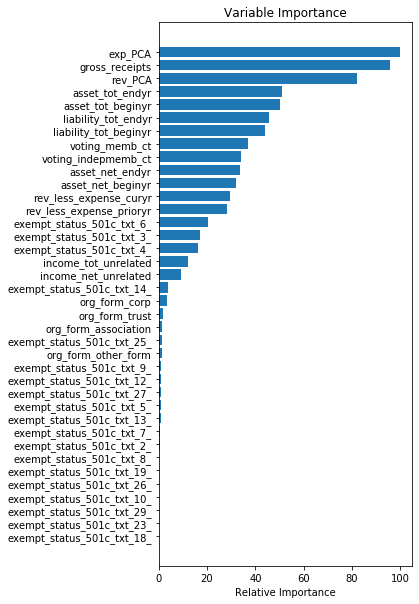

In [442]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [291]:
rfc.feature_importances_

array([5.19172034e-04, 1.42917946e-04, 5.23567063e-05, 1.00340838e-04,
       1.37763663e-01, 2.77509717e-02, 3.26197879e-02, 3.68718475e-03,
       1.95316209e-03, 5.70364784e-03, 5.33833289e-02, 6.70136778e-02,
       3.29597231e-02, 7.60667048e-03, 3.91533004e-02, 3.85667368e-02,
       2.23576947e-02, 1.65760685e-01, 1.11107039e-01, 1.74067185e-01,
       0.00000000e+00, 8.08741309e-04, 1.80827384e-04, 9.19343338e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.52494755e-03,
       0.00000000e+00, 1.77633474e-04, 0.00000000e+00, 0.00000000e+00,
       2.68762097e-02, 2.10584796e-02, 7.18473126e-04, 1.65371771e-02,
       0.00000000e+00, 0.00000000e+00, 6.54832595e-04])

<a id="support_vector_classifier"></a>

### Support Vector Classifier

In [355]:
# use grid search to fine tune parameters
param_grid = {'C':[.0000001, .000001, .00001, .0001, .001],
             'gamma': ['scale', 'auto'],
             'class_weight': ['balanced']}
svc = SVC()

gsearch = GridSearchCV(svc, param_grid, cv=5)
                       
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'class_weight': ['balanced'],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [356]:
gsearch.best_params_

{'C': 1e-05, 'class_weight': 'balanced', 'gamma': 'scale'}

In [448]:
svc = SVC(gamma='scale', C= .00001, class_weight=  'balanced')

svc.fit(X_train, y_train)

SVC(C=1e-05, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The grid search above produced parameters that voted exclusively in one direction, leading to lopsided results.  Instead I found the best parameters to be a C value of 1 with verbose=True, gamma='scale', class_weight='balanced', which I have used in the below svc model.

In [488]:
svc = SVC(gamma='scale', C= 1, class_weight=  'balanced', verbose=True)

svc.fit(X_train, y_train)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [492]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.016648065476190476
Percent Type II errors: 0.10105096726190477

Test set accuracy:
Percent Type I errors: 0.01710991259066394
Percent Type II errors: 0.09429049655941975


In [490]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,18786,358
Actual: Yes,2173,187


In [491]:
# testing results

pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4736,92
Actual: Yes,507,42


<a id="knn"></a>

## KNN Classifier

In [474]:
# use grid search to fine tune parameters
param_grid = {'n_neighbors': range(80, 121, 10),
             'leaf_size': [.5, 1, 2]}

knn_clf = KNeighborsClassifier()

gsearch = GridSearchCV(knn_clf, param_grid, cv=5)
                       
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [1, 2],
                         'n_neighbors': range(80, 121, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [482]:
gsearch.best_params_

{'leaf_size': 1, 'n_neighbors': 110}

In [478]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [463]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [479]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.002464657738095238
Percent Type II errors: 0.10546875

Test set accuracy:
Percent Type I errors: 0.0022317277292170355
Percent Type II errors: 0.09838199739631764


In [480]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19091,53
Actual: Yes,2268,92


In [481]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4816,12
Actual: Yes,529,20


<a id="gradient_boost_classifier"></a>

### Gradient Boost Classifier

In [363]:
param_test = {'n_estimators':range(700, 1001,50),
              'learning_rate': [0.05, .1, .5],
              'max_depth': [2],
              'subsample': [.2, .4, .6, .8, 1]}

gbc = ensemble.GradientBoostingClassifier(
           max_features='sqrt',
           random_state=10)

gsearch = GridSearchCV(gbc, 
           param_grid = param_test, 
           scoring='roc_auc',
           n_jobs=4, iid=False, cv=5)

gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_...nge=None,
                                                  presort='

In [364]:
gsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 950, 'subsample': 0.8}

In [518]:
X.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,rev_PCA,exp_PCA,exempt_status_501c_txt_10_,exempt_status_501c_txt_12_,exempt_status_501c_txt_13_,exempt_status_501c_txt_14_,exempt_status_501c_txt_18_,exempt_status_501c_txt_19_,exempt_status_501c_txt_23_,exempt_status_501c_txt_25_,exempt_status_501c_txt_26_,exempt_status_501c_txt_27_,exempt_status_501c_txt_29_,exempt_status_501c_txt_2_,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_5_,exempt_status_501c_txt_6_,exempt_status_501c_txt_7_,exempt_status_501c_txt_8_,exempt_status_501c_txt_9_
0,True,False,False,False,15549792,11,11,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,-9.230988e+07,-7.560677e+07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,False,False,False,9472036,9,8,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,-1.057983e+08,-9.231641e+07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,8503978,21,19,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,-1.072903e+08,-9.229491e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,True,False,False,False,57422298,8,7,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,-1.765087e+07,-1.757254e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,True,False,False,False,5974176,12,12,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,-1.162458e+08,-9.964548e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [510]:
# fit model based on grid search parameters
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=950,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [511]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.003720238095238095
Percent Type II errors: 0.08384486607142858

Test set accuracy:
Percent Type I errors: 0.01301841175376604
Percent Type II errors: 0.08536358564255161


In [512]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19064,80
Actual: Yes,1803,557


In [513]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4758,70
Actual: Yes,459,90


Gradient Boost Classifier did a much better job of predicting Yes

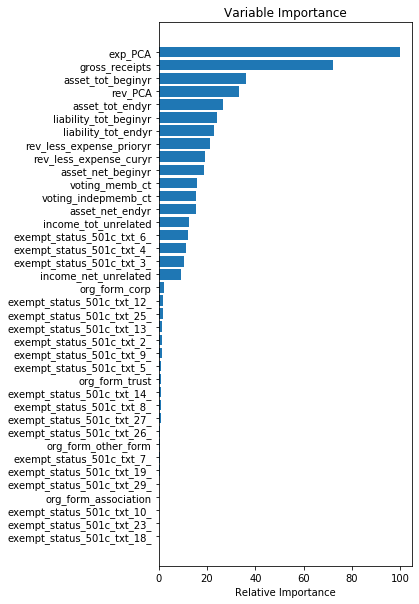

In [514]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [515]:
# find insignificant features
clf_features = pd.DataFrame(clf.feature_importances_,
            X.columns, columns=['importance'])

clf_features[(clf_features < .004).iloc[:,0]].index

Index(['org_form_trust', 'org_form_association', 'org_form_other_form',
       'exempt_status_501c_txt_10_', 'exempt_status_501c_txt_12_',
       'exempt_status_501c_txt_13_', 'exempt_status_501c_txt_14_',
       'exempt_status_501c_txt_18_', 'exempt_status_501c_txt_19_',
       'exempt_status_501c_txt_23_', 'exempt_status_501c_txt_25_',
       'exempt_status_501c_txt_26_', 'exempt_status_501c_txt_27_',
       'exempt_status_501c_txt_29_', 'exempt_status_501c_txt_2_',
       'exempt_status_501c_txt_5_', 'exempt_status_501c_txt_7_',
       'exempt_status_501c_txt_8_', 'exempt_status_501c_txt_9_'],
      dtype='object')

In [516]:
# examine how model flagged specific orgs
# concatenate X, y, and predictions
pd.concat([X, pd.DataFrame(predict_test), y], axis=1)[(pd.concat([X, pd.DataFrame(predict_test), y], axis=1).loc[:,0] == True) &
                                                     (pd.concat([X, pd.DataFrame(predict_test), y], axis=1).loc[:,'TARGET_FEATURE'] == True)].head(10)

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,rev_PCA,exp_PCA,exempt_status_501c_txt_10_,exempt_status_501c_txt_12_,exempt_status_501c_txt_13_,exempt_status_501c_txt_14_,exempt_status_501c_txt_18_,exempt_status_501c_txt_19_,exempt_status_501c_txt_23_,exempt_status_501c_txt_25_,exempt_status_501c_txt_26_,exempt_status_501c_txt_27_,exempt_status_501c_txt_29_,exempt_status_501c_txt_2_,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_5_,exempt_status_501c_txt_6_,exempt_status_501c_txt_7_,exempt_status_501c_txt_8_,exempt_status_501c_txt_9_,0,TARGET_FEATURE
319,True,False,False,False,535136,18,18,0,0.0,337113.0,787062.0,13131.0,773931.0,-124720,660240,6999,653241,-1.227172e+08,-1.040853e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
444,True,False,False,False,50049226,14,14,0,0.0,675468.0,9600399.0,7235574.0,2364825.0,-447863,9368712,7451750,1916962,-6.939333e+07,-2.137556e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
1345,True,False,False,False,1291055,23,23,0,0.0,183243.0,1179362.0,234022.0,945340.0,20843,1202521,236338,966183,-1.207786e+08,-1.027279e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,True
2435,True,False,False,False,13693087,8,3,0,0.0,34076.0,9584839.0,15888046.0,-6303207.0,6382987,0,0,0,-1.111906e+08,-9.267509e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
2783,True,False,False,False,41864357,39,39,0,0.0,10307941.0,26835597.0,12932425.0,13903172.0,-13230455,14931339,15682634,-751295,-2.003900e+07,-3.463298e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
2949,True,False,False,False,4416675,10,4,1047071,127569.0,314080.0,6127797.0,712952.0,5414845.0,676566,6511295,532898,5978397,-1.158456e+08,-9.855986e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
3317,True,False,False,False,2616566,28,28,0,0.0,12608.0,1286768.0,103115.0,1183653.0,-44581,1265328,126256,1139072,-1.184896e+08,-1.002810e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
3967,True,False,False,False,49307276,14,14,0,0.0,2263421.0,62306387.0,6833114.0,55473273.0,10673844,73781858,8599177,65182681,-1.128927e+08,-1.005189e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
4130,True,False,False,False,1781337070,20,18,0,0.0,-37956244.0,805443960.0,390641859.0,414802101.0,27055270,733259803,290965228,442294575,2.942822e+09,1.798800e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True
4222,True,False,False,False,545736,14,14,0,0.0,-5086.0,555539.0,502085.0,53454.0,5727,543290,483162,60128,-1.223380e+08,-1.041184e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True


### Export dataset to be able to model further feature iterations

In [517]:
df.to_csv('data/990_model_data_2.csv', index=None, header=True)